 # Stock Price Forecasting using LSTM in Bhutan's Stock Market

## This study utilizes LSTM (Long Short-Term Memory) neural networks to predict stock prices of **Bhutan Tourism Corporation Limited (BTCL)** from the **Royal Securities Exchange of Bhutan (RSEB)**.




In [1]:
# Importing the necessary library for this LSTM model
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## The methodology is broken into three phases: data collection, data preprocessing, and model implementation.



# 1. Data Collection
Data was collected from the Royal Securities Exchange of Bhutan (RSEB) and covered a period of 5 years from 2020 to 2025. The dataset included daily closing prices of Bhutan Tourism Corporation Limited(BTCL) listed on the exchange. 




 # 2. Exploratory Data Analysis (EDA)
 

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)


In [3]:

# Load dataset (replace with actual path to your dataset)
file_path = '/kaggle/input/chart2-csv/chart.csv'
df = pd.read_csv(file_path)

# Preview the data
print(df)


                 DateTime    BTCL
0     2020-04-23 06:34:02  158.45
1     2020-04-23 09:34:02  158.45
2     2020-04-24 06:34:01  158.45
3     2020-04-24 09:34:02  158.45
4     2020-04-27 06:33:57  158.45
...                   ...     ...
5899  2025-04-25 03:56:15  570.00
5900  2025-04-25 04:56:11  570.00
5901  2025-04-25 05:56:18  570.00
5902  2025-04-25 07:56:13  570.00
5903  2025-04-25 08:56:13  570.00

[5904 rows x 2 columns]


In [4]:
df.describe() #summary of the datasets

,BTCL
count,5904.000000
mean,556.576179
std,316.098800
min,40.000000
25%,203.700000
50%,684.530000
75%,845.740000
max,1178.570000


In [5]:
#Checking if there is any missing values
df.isna().sum()


DateTime    0
BTCL        0
dtype: int64

In [6]:


# Convert DateTime column to datetime object
df['DateTime'] = pd.to_datetime(df['DateTime'])
# Create interactive plot
fig = px.line(df, 
              x='DateTime', 
              y='BTCL',
              title='BTCL Price Over Time',
              labels={'BTCL': 'Price (Ngultrum)', 'DateTime': 'Date'},
              template='plotly_white')

# Add customization
fig.update_layout(
    hovermode='y unified',  # Show hover data for all points on x-axis
    xaxis_title='Date',
    yaxis_title='BTCL Price',
    xaxis_rangeslider_visible=True  # Adds zoom slider at bottom
)

# Add hover data formatting
fig.update_traces(
    hovertemplate='<b>%{x|%Y-%m-%d}</b><br>Price: Nu.%{y:.2f}'
)

# Show the plot
fig.show()



 # 3. Data Preprocessing

 The collected data from RSEBL was cleaned to omit duplicate values, as the trading price for each day was given multiple times of the day . Afterward, the data was normalized using Min-Max scaling to ensure all values were between 0 and 1, which helps in improving the convergence of the LSTM model. 
The dataset was then split into training and testing sets, with 80% allocated for training and the remaining 20% for testing. For time-series forecasting, sliding windows of historical data points were created as input features, with the corresponding future value of the stock price being the output label.


In [7]:
# Convert to datetime and extract just the date
df['DateTime'] = pd.to_datetime(df['DateTime']).dt.date

# Keep the last record of each day
daily_df = df.groupby('DateTime').last().reset_index()

# Save the cleaned data
daily_df.to_csv('cleaned_stock_data.csv', index=False)

# Display the cleaned DataFrame and min/max values
print(daily_df)
print("Min value of BTCL stock:", daily_df.min())
print("Max value of BTCL stock:", daily_df.max())


        DateTime    BTCL
0     2020-04-23  158.45
1     2020-04-24  158.45
2     2020-04-27  158.45
3     2020-04-28  158.45
4     2020-04-29  158.45
...          ...     ...
1225  2025-04-21  570.00
1226  2025-04-22  570.00
1227  2025-04-23  570.00
1228  2025-04-24  570.00
1229  2025-04-25  570.00

[1230 rows x 2 columns]
Min value of BTCL stock: DateTime    2020-04-23
BTCL              40.0
dtype: object
Max value of BTCL stock: DateTime    2025-04-25
BTCL           1178.57
dtype: object


In [8]:
daily_df.describe().round(2)

,BTCL
count,1230.00
mean,541.98
std,319.02
min,40.00
25%,203.70
50%,650.00
75%,845.74
max,1178.57


In [9]:

from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split

# Use only 'Close' price for modeling, .reshape(-1, 1) converts a 1D array to 2D with one column.
prices = daily_df['BTCL'].values.reshape(-1, 1)

# MinMaxScaler class from scikit-learn's preprocessing module Normalizes the prices in [0, 1] range
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

#Displaying the normalised Data
print("Min value after scaling:", scaled_prices.min())
print("Max value after scaling:", scaled_prices.max())
print(scaled_prices)

Min value after scaling: 0.0
Max value after scaling: 1.0
[[0.10403401]
 [0.10403401]
 [0.10403401]
 ...
 [0.46549619]
 [0.46549619]
 [0.46549619]]


# 4. Model Implementation using LSTM

The LSTM model was developed using Python ’s TensorFlow library. LSTM was selected due to its capacity to capture long-term dependencies in time-series data by retaining memory of past values. The model was initialized with two LSTM layers, each containing 100 units, followed by a dense layer for the final output. The loss function used was Mean Squared Error (MSE), and the Adam optimizer was applied for gradient-based optimization.
The model was trained for 50 epochs, and hyperparameters such as learning rate, batch size, and sequence length were fine-tuned using grid search. Early stopping was applied to prevent overfitting.


In [10]:
# Create sliding window features
#For each day, it: X (Input): Stores the past window_size days (e.g., 60 days) as a "window." y (Target): Stores the next day's price (what we want to predict).

def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_dataset(scaled_prices, window_size)

# Reshape for LSTM input: [samples, time steps, features] since LSTMs (and most deep learning models for sequences) require input in 3 dimensions:
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split 80% Training: Used to teach the model. 20% Testing: Used to check if the model predicts well on unseen data.
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [11]:
#Checks the dimensions of your input (X) and output (y) data.
print("X shape:", X.shape)  # Should be (n_samples, window_size, 1) after reshaping
print("y shape:", y.shape)  # Should be (n_samples,)

# Peek at the first input-output pair
print("First input sequence (X[0]):", X[0].flatten())  # Flatten to print as 1D
print("First target value (y[0]):", y[0])

#Confirms X is now in the correct 3D format for LSTMs.
print("LSTM-ready X shape:", X.shape)

#Checking to see if no data leakage between train and test sets.
print("Last value in X_train:", X_train[-1].flatten()[-1])
print("First value in X_test:", X_test[0].flatten()[0])


X shape: (1170, 60, 1)
y shape: (1170,)
First input sequence (X[0]): [0.10403401 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401
 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401
 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401
 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401
 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401
 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401
 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401
 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401
 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401
 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401 0.10403401]
First target value (y[0]): 0.10403400757090032
LSTM-ready X shape: (1170, 60, 1)
Last value in X_train: 0.5796745039830665
First value in X_test: 0.5796745039830665


In [12]:


# Build LSTM model with Input layer first
model = Sequential([
    Input(shape=(X_train.shape[1], 1)),  # Explicit Input layer
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(1)
])

model.compile(optimizer=Adam(), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0690 - val_loss: 0.0051
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 7.7357e-04 - val_loss: 0.0019
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 6.6742e-04 - val_loss: 0.0018
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 5.9798e-04 - val_loss: 0.0017
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 5.2444e-04 - val_loss: 0.0016
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 4.7940e-04 - val_loss: 0.0016
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 4.8835e-04 - val_loss: 0.0018
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 5.5012e-04 - val_loss: 0.0016
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 4.7911e-04 - val_loss: 0.0016
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 4.7217e-04 - val_loss: 0.0016
Epoch 12/50
30/30 ━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
           Date  Actual Price  Predicted Price
0    2020-07-20        158.45       161.794388
1    2020-07-21        158.45       161.794388
2    2020-07-22        158.45       161.794388
3    2020-07-23        158.45       161.794388
4    2020-07-27        158.45       161.794388
..          ...           ...              ...
229  2025-04-21        570.00       580.106873
230  2025-04-22        570.00       580.942810
231  2025-04-23        570.00       581.499268
232  2025-04-24        570.00       581.791931
233  2025-04-25        570.00       581.879089

[1170 rows x 3 columns]


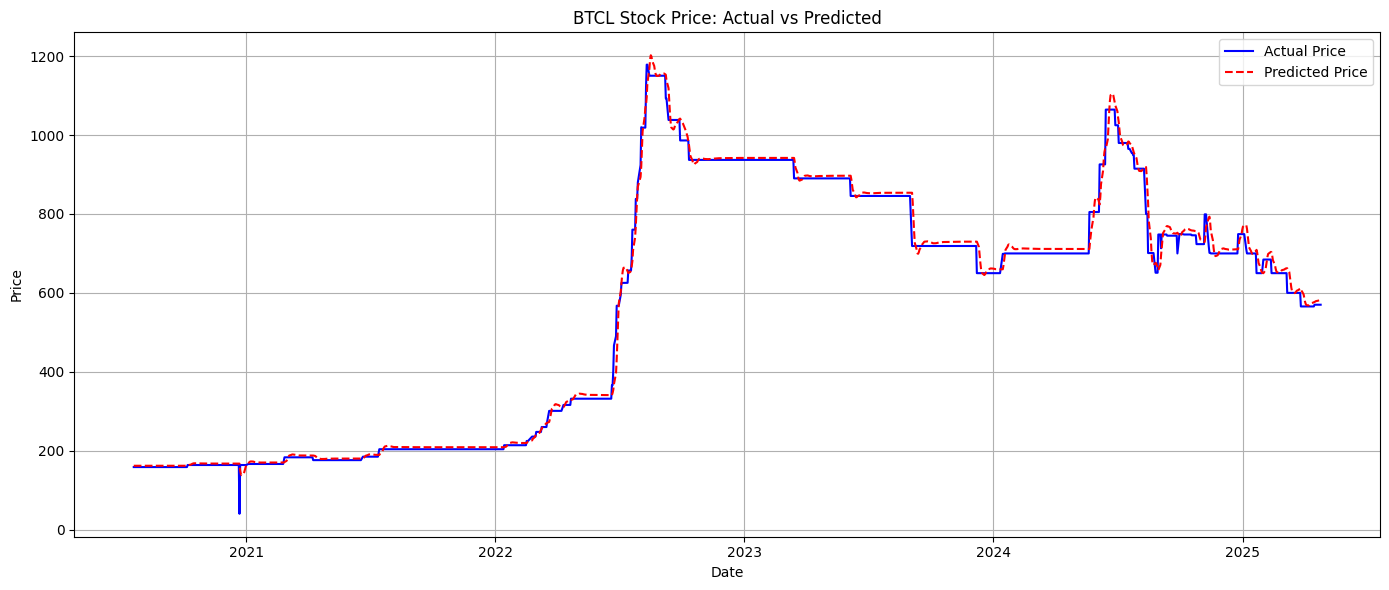

In [13]:

# After training the model, you can predict both on training and testing sets
# Predict on training data (y_train)
train_pred = model.predict(X_train)
train_pred = scaler.inverse_transform(train_pred.reshape(-1, 1))

# Predict on testing data (y_test)
test_pred = model.predict(X_test)
test_pred = scaler.inverse_transform(test_pred.reshape(-1, 1))

# Inverse scale the actual values for training and testing sets
actual_train = scaler.inverse_transform(y_train.reshape(-1, 1))
actual_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create dates for training and testing periods
train_dates = daily_df['DateTime'].values[window_size:split+window_size]
test_dates = daily_df['DateTime'].values[split+window_size:]

# Combine training and testing results
train_results = pd.DataFrame({
    'Date': train_dates,
    'Actual Price': actual_train.flatten(),
    'Predicted Price': train_pred.flatten()
})

test_results = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': actual_test.flatten(),
    'Predicted Price': test_pred.flatten()
})

# Concatenate both
full_results = pd.concat([train_results, test_results])

# Display the combined result (actual vs predicted)
print(full_results)

# Plot the actual vs predicted prices using matplotlib
plt.figure(figsize=(14,6))
plt.plot(full_results['Date'], full_results['Actual Price'], label='Actual Price', color='blue')
plt.plot(full_results['Date'], full_results['Predicted Price'], label='Predicted Price', linestyle='dashed', color='red')
plt.title('BTCL Stock Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Model Evaluation

To evaluate the performance of the LSTM model, four standard regression metrics were computed using the actual and predicted stock prices. These included Mean Squared Error (MSE), which quantifies the average squared difference between predicted and actual values, and its square root, the Root Mean Squared Error (RMSE), which provides error in the same units as the stock price. The Mean Absolute Error (MAE) was also calculated to represent the average magnitude of prediction errors, offering an interpretable measure of accuracy. Lastly, the R² Score (Coefficient of Determination) was used to assess the proportion of variance in the actual prices explained by the model. These metrics were computed using the scikit-learn library in Python, and together they provided a comprehensive evaluation of the model’s predictive performance.


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Calculate evaluation metrics
mse = mean_squared_error(full_results['Actual Price'], full_results['Predicted Price'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(full_results['Actual Price'], full_results['Predicted Price'])
r2 = r2_score(full_results['Actual Price'], full_results['Predicted Price'])


# Print them
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")



Mean Squared Error (MSE): 435.5070
Root Mean Squared Error (RMSE): 20.8688
Mean Absolute Error (MAE): 12.0916
R² Score: 0.9956


# 6. Future Prediction

The code defines a function predict_future that uses a trained LSTM model to forecast future stock prices by iteratively predicting one day at a time based on the last known sequence of data. It then generates a DataFrame of predicted prices for the next 30 days, along with corresponding future dates. The results are visualized in a comprehensive plot that displays actual historical prices, training and testing predictions (if available), and future forecasts, each in distinct colors and line styles for clarity. This allows for a clear comparison between past performance and projected trends.

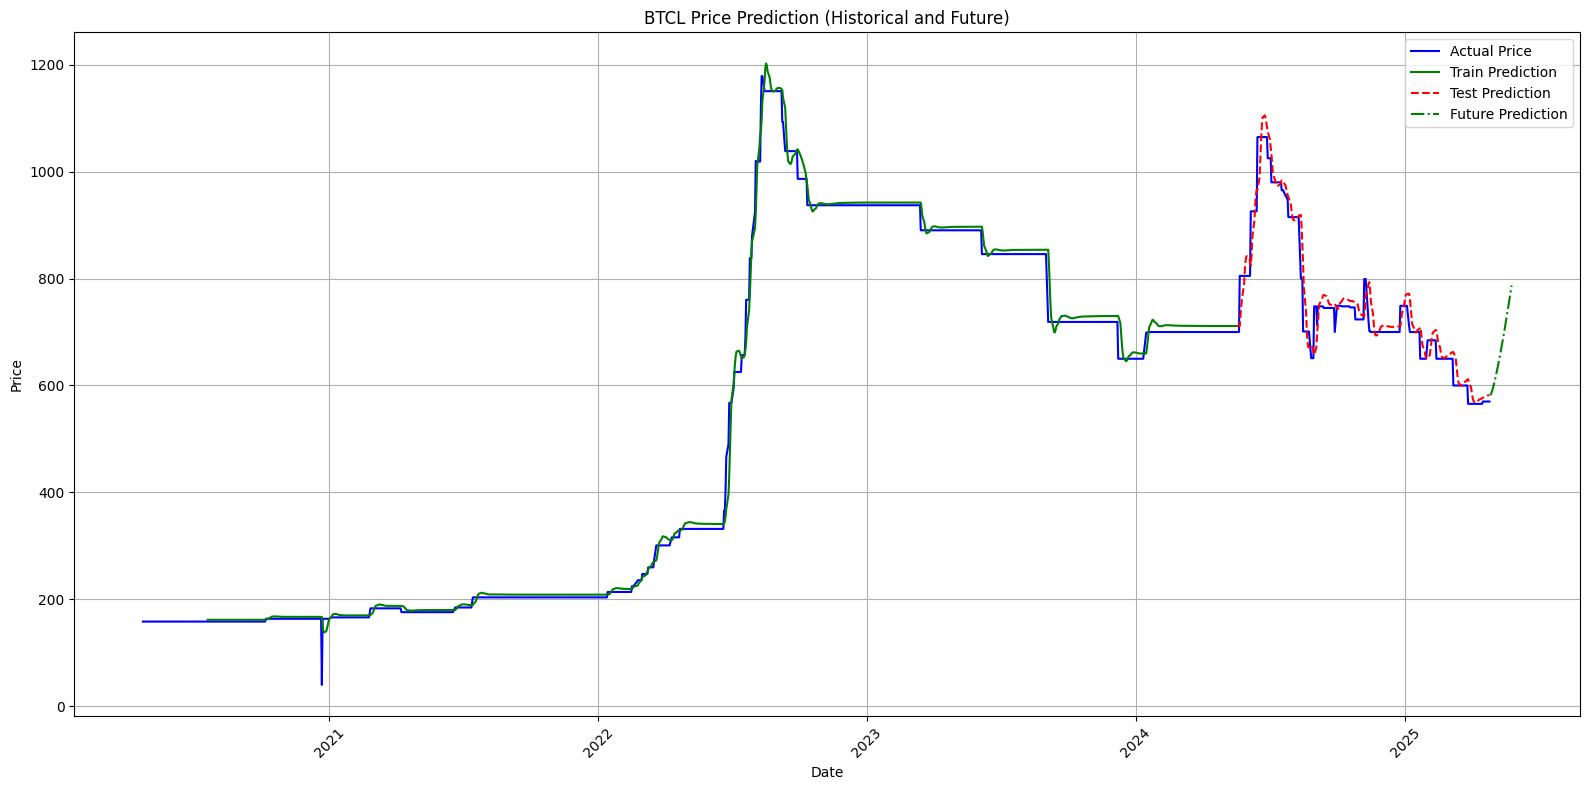

In [15]:

# Fixed predict_future function
def predict_future(model, data, days, scaler, window_size):
    future_preds = []
    last_sequence = data[-window_size:].reshape(1, window_size, 1)
    for _ in range(days):
        next_pred = model.predict(last_sequence, verbose=0)[0][0]  # Added verbose=0
        future_preds.append(next_pred)
        last_sequence = np.append(last_sequence[:, 1:, :], [[[next_pred]]], axis=1)
    return scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Generate future predictions
future_days = 30
future_pred = predict_future(model, scaled_prices, future_days, scaler, window_size)

# Create future dates (check column name in daily_df)
date_column = 'DateTime' if 'DateTime' in daily_df.columns else daily_df.columns[0]  # Fallback to first column
last_date = pd.to_datetime(daily_df[date_column].iloc[-1])
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days)

future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_pred.flatten()
})

# Plot with column name checks
plt.figure(figsize=(16, 8))

# Plot actual prices
plt.plot(pd.to_datetime(daily_df[date_column]), 
         daily_df['BTCL'], 
         label='Actual Price', color='blue')

# Check and plot train results if available
if 'train_results' in locals():
    train_date_col = 'DateTime' if 'DateTime' in train_results.columns else train_results.columns[0]
    plt.plot(pd.to_datetime(train_results[train_date_col]), 
             train_results['Predicted Price'], 
             label='Train Prediction', color='green')

# Check and plot test results if available
if 'test_results' in locals():
    test_date_col = 'DateTime' if 'DateTime' in test_results.columns else test_results.columns[0]
    plt.plot(pd.to_datetime(test_results[test_date_col]), 
             test_results['Predicted Price'], 
             label='Test Prediction', linestyle='--', color='red')

# Plot future predictions
plt.plot(future_df['Date'], 
         future_df['Predicted_Price'], 
         label='Future Prediction', linestyle='-.', color='green')

plt.title('BTCL Price Prediction (Historical and Future)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()
plt.show()

# 7. Generate Buy/Sell Signals

This code performs a simple backtesting simulation using buy/sell signals generated from LSTM-predicted stock prices. It first filters out any rows with missing values, then assigns trading signals: buy if the predicted price is higher than the actual price, sell if lower, and hold otherwise. Starting with an initial capital of Nu.100,000, it simulates trading one unit per signal, updating the cash balance and position accordingly, and calculates the portfolio value each day. The results include daily returns and total return, which are printed and plotted over time. Additionally, it visualizes buy/sell signals on a price chart to show where the model suggested trades based on its predictions.


Final Portfolio Value: 228,703.23
Total Return: 128.70%


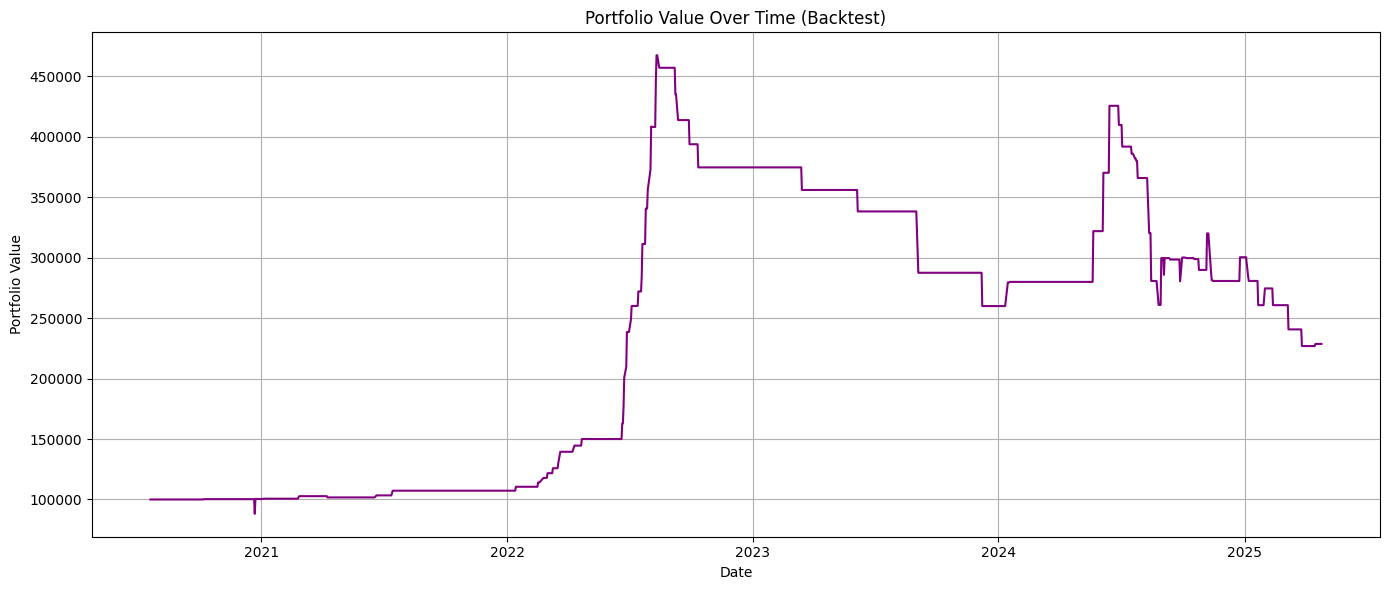

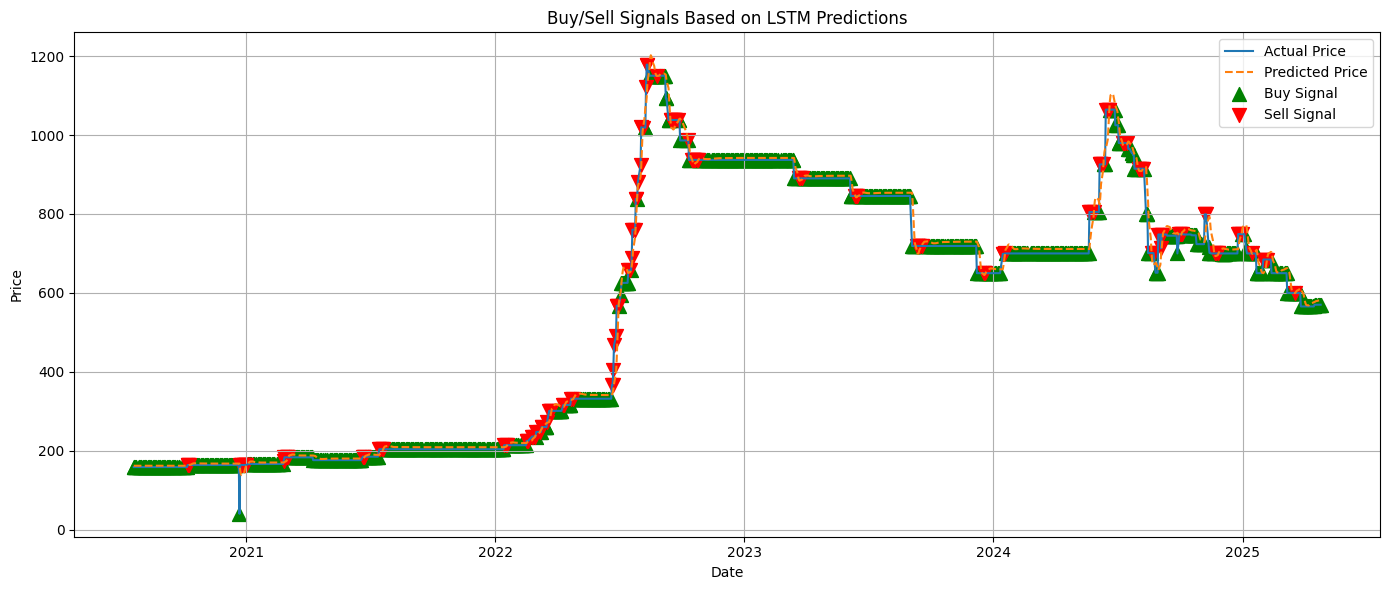

In [16]:
# Drop rows with missing values in either column
filtered_df = full_results.dropna(subset=['Actual Price', 'Predicted Price'])

# Step 1: Generate Buy/Sell Signals
filtered_df['Signal'] = 0  # 0 = Hold
filtered_df.loc[filtered_df['Predicted Price'] > filtered_df['Actual Price'], 'Signal'] = 1  # Buy
filtered_df.loc[filtered_df['Predicted Price'] < filtered_df['Actual Price'], 'Signal'] = -1 # Sell

# Step 2: Simulate Trading - Simple Backtest
initial_capital = 100000  # Starting with 100,000 units of currency
position = 0  # Number of shares held
cash = initial_capital
portfolio_values = []  # To track daily portfolio value

# Assume you buy/sell one unit each time a signal triggers
for i in range(len(filtered_df)):
    price = filtered_df.iloc[i]['Actual Price']
    signal = filtered_df.iloc[i]['Signal']

    if signal == 1:  # Buy
        if cash >= price:
            position += 1
            cash -= price
    elif signal == -1:  # Sell
        if position > 0:
            position -= 1
            cash += price
    
    # Portfolio = cash + (current price * shares held)
    total_value = cash + position * price
    portfolio_values.append(total_value)

# Add portfolio values to the DataFrame
filtered_df['Portfolio Value'] = portfolio_values

# Step 3: Calculate Returns
filtered_df['Daily Return (%)'] = filtered_df['Portfolio Value'].pct_change() * 100
total_return = (filtered_df['Portfolio Value'].iloc[-1] - initial_capital) / initial_capital * 100

# Print Summary
print(f"\nFinal Portfolio Value: {filtered_df['Portfolio Value'].iloc[-1]:,.2f}")
print(f"Total Return: {total_return:.2f}%")

# Step 4: Plot Portfolio Value Over Time
plt.figure(figsize=(14,6))
plt.plot(filtered_df['Date'], filtered_df['Portfolio Value'], color='purple')
plt.title('Portfolio Value Over Time (Backtest)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Plot Buy/Sell Signals
plt.figure(figsize=(14,6))
plt.plot(filtered_df['Date'], filtered_df['Actual Price'], label='Actual Price')
plt.plot(filtered_df['Date'], filtered_df['Predicted Price'], label='Predicted Price', linestyle='dashed')
plt.scatter(filtered_df[filtered_df['Signal'] == 1]['Date'], 
            filtered_df[filtered_df['Signal'] == 1]['Actual Price'], 
            label='Buy Signal', marker='^', color='green', s=100)
plt.scatter(filtered_df[filtered_df['Signal'] == -1]['Date'], 
            filtered_df[filtered_df['Signal'] == -1]['Actual Price'], 
            label='Sell Signal', marker='v', color='red', s=100)
plt.title('Buy/Sell Signals Based on LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Signal.png", dpi=300, bbox_inches='tight')
plt.show()
